In [1]:
!pip install audiomentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.3 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.0.post2
    Uninstalling librosa-0.10.0.post2:
      Successfully uninstalled librosa-0.10.0.post2


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import wavfile
import os.path
import IPython.display
import seaborn as sns
import librosa
import librosa.display
import soundfile
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers

from keras import optimizers,regularizers
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.decomposition import PCA
import warnings

In [2]:
!pip install pydub
!pip install audiomentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
import os
import wave
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydub import AudioSegment
from IPython.display import Audio, display
import librosa as lib
import librosa.display

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
PATH = "/content/drive/MyDrive/Colab Notebooks/Crema"
AUDIO_PATH = "/content/drive/MyDrive/Colab Notebooks/Crema/1001_DFA_ANG_XX.wav"

In [ ]:
def zeroCrossingRate(audio):
  return lib.feature.zero_crossing_rate(audio)

In [ ]:
def energy(audio):
  # using a spectrogram will give a more accurate representation
  # of energy over time because its frames can be windowed
  S, phase = lib.magphase(lib.stft(audio))
  return lib.feature.rms(S=S).mean()

In [ ]:
def chromaStft(audio, sr):
  stft = np.abs(librosa.stft(audio))
  return librosa.feature.chroma_stft(S=stft, sr=sr, n_fft=200).mean()

In [ ]:
def mfcc(data, sr):
  return librosa.feature.mfcc(y=data, sr=sr, n_fft=200).mean()

In [ ]:
def melSpectrogram(audio, sr):
  mel_spectrogram = lib.feature.melspectrogram(y=audio, sr=sr, n_fft=200, n_mels=64)
  log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
  return log_mel_spectrogram

In [ ]:
def playAudio(audio_file):
  audio = AudioSegment.from_wav(audio_file)
  # Play the audio
  audio.export('temp_audio.wav', format='wav')
  audio_data = open('temp_audio.wav', 'rb').read()
  display(Audio(audio_data))
  # Delete the temporary audio file
  os.remove('temp_audio.wav')

In [ ]:
def visualize_waveform(audio, sr):
    plt.figure(figsize=(12, 4))
    plt.plot(audio)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Waveform')
    plt.show()

In [ ]:
def splitData(dataset_path):
  audio_files = glob.glob(os.path.join(dataset_path, "*.wav"))
  audio_train, audio_test = train_test_split(audio_files, test_size=0.3, random_state=42, shuffle=True)
  return audio_train, audio_test

In [ ]:
D_train, D_test = splitData(PATH)

In [ ]:
print(len(D_train), len(D_test))

In [ ]:
D_test[0]

In [171]:
def getMaxLen(audio_files):
  max_length = 0
  for audio_file in audio_files:
    audio, _ = librosa.load(audio_file)
    length = len(audio)
    max_length = max(max_length, length)
  return max_length

In [218]:
def loadAudioTime(audio_files):
  classes = ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"]
  
  # max_length = getMaxLen(audio_files)
  max_length = 200
  D, Y = [], []
  for audio_file in audio_files: 
    # load the audio file
    audio, sr = lib.load(audio_file, sr=4444)
    # extract zero crossing rate
    zcr = zeroCrossingRate(audio)
    # extract energy
    rms = energy(audio)
    # chroma stft
    cs = chromaStft(audio, sr)
    # mfcc
    mfc = mfcc(audio, sr)
    # extract mel spectrogram
    #mel_spec = melSpectrogram(audio, sr).mean()
    combined_features = np.concatenate(([rms, cs, mfc], (np.pad(zcr[0], (0, 300 - len(zcr[0]))))))
    D.append(combined_features)
    for cls in classes:
      if re.search(cls, audio_file): Y.append(cls)
  
  return D, Y

In [65]:
def loadAudioFreq(audio_files):
  classes = ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"]
 
  # max_length = getMaxLen(audio_files)
  max_length = 200
  D, Y = [], []
  for audio_file in audio_files: 
    # load the audio file
    audio, sr = lib.load(audio_file, sr=4444)
    # extract mel spectrogram
    mel_spec = melSpectrogram(audio, sr)
    D.append(mel_spec)
    for cls in classes:
      if re.search(cls, audio_file): Y.append(cls)
    
  return D, Y

## Time Domain Model Without Augmentation

In [219]:
D_time, Y_time = loadAudioTime(D_train)

/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


In [220]:
D_time = np.array(D_time)
D_time.shape

(5216, 303)

In [221]:
unicheck = np.unique(Y_time, axis=0)
print(f"Check on time domain:\n{unicheck}")

Check on time domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [222]:
df_time = pd.DataFrame(Y_time)
df_time.head()

,0
0,DIS
1,FEA
2,DIS
3,SAD
4,ANG


In [223]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_time)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(5216, 6)


In [224]:
Y_time = one_hot_labels
Y_time.shape

(5216, 6)

In [225]:
# Apply PCA to the data
pca = PCA(n_components=100)
D_pca = pca.fit_transform(D_time)

In [226]:
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(np.array(D_pca), np.array(Y_time), test_size=0.05, random_state=69, shuffle=True, stratify=Y_time)
print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

model = Sequential()
model.add(Conv1D(128, 3, input_shape=(x_train.shape[1], 1), kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(256, 3, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(512, 3, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(1024, 3,  kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(512, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(lr=0.0005),
             metrics=['accuracy'])

# Specify thecallbacks for the model
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

model.summary()

# Train the model with early stopping
history = model.fit(x_train, y_train,
                    validation_data=(x_train, y_train),
                    epochs=50,
                    batch_size=32,
                    callbacks=callbacks)

((4955, 100), (4955, 6), (261, 100), (261, 6))
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 98, 128)           512       
                                                                 
 batch_normalization_28 (Bat  (None, 98, 128)          512       
 chNormalization)                                                
                                                                 
 activation_28 (Activation)  (None, 98, 128)           0         
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 49, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 47, 256)           98560     
                                                                 
 batch_

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
155/155 [==============================] - 6s 18ms/step - loss: 3.7618 - accuracy: 0.3039 - val_loss: 4.0873 - val_accuracy: 0.1493
Epoch 2/50
155/155 [==============================] - 2s 14ms/step - loss: 3.1366 - accuracy: 0.3479 - val_loss: 3.9501 - val_accuracy: 0.1491
Epoch 3/50
155/155 [==============================] - 2s 14ms/step - loss: 2.8334 - accuracy: 0.3639 - val_loss: 3.2142 - val_accuracy: 0.1655
Epoch 4/50
155/155 [==============================] - 2s 14ms/step - loss: 2.6468 - accuracy: 0.3689 - val_loss: 2.7124 - val_accuracy: 0.2844
Epoch 5/50
155/155 [==============================] - 3s 20ms/step - loss: 2.5027 - accuracy: 0.3841 - val_loss: 2.4044 - val_accuracy: 0.4010
Epoch 6/50
155/155 [==============================] - 3s 17ms/step - loss: 2.3914 - accuracy: 0.3952 - val_loss: 2.3440 - val_accuracy: 0.4002
Epoch 7/50
155/155 [==============================] - 2s 14ms/step - loss: 2.3111 - accuracy: 0.4000 - val_loss: 2.2625 - val_accuracy: 0.4139

In [227]:
X_test_time,Y_test_time = loadAudioTime(D_test)
D_test_pca = pca.transform(X_test_time)

In [228]:
unicheck = np.unique(Y_test_time, axis=0)
print(f"Check on freq domain:\n{unicheck}")

Check on freq domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [229]:
df_freq = pd.DataFrame(Y_test_time)
df_freq.head()

,0
0,NEU
1,DIS
2,HAP
3,NEU
4,DIS


In [230]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_freq)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(2236, 6)


In [231]:
Y_time = one_hot_labels
Y_time.shape

(2236, 6)

70/70 [==============================] - 1s 5ms/step
Accuracy: 0.31932021466905186
F-score: 0.2650554931782003


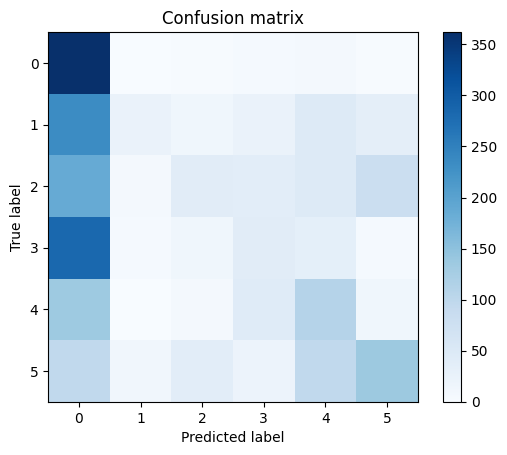

Most confusing classes: (3, 0)


In [232]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# Evaluate the model on the test set
y_pred = model.predict(D_test_pca)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(Y_time, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
f_score = f1_score(y_test_classes, y_pred_classes, average='weighted')
print('Accuracy:', accuracy)
print('F-score:', f_score)

# Plot the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(6)
plt.xticks(tick_marks, range(6))
plt.yticks(tick_marks, range(6))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Find the most confusinglabels
np.fill_diagonal(cm, 0)
most_confused_classes = np.unravel_index(np.argmax(cm), cm.shape)
print('Most confusing classes:', most_confused_classes)

## Frequency Domain Model Without Augmentation

In [138]:
D_freq, Y_freq = loadAudioFreq(D_train)

In [140]:
unicheck = np.unique(Y_freq, axis=0)
print(f"Check on freq domain:\n{unicheck}")

Check on freq domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [141]:
df_freq = pd.DataFrame(Y_freq)
df_freq.head()

,0
0,DIS
1,FEA
2,DIS
3,SAD
4,ANG


In [142]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_freq)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(5216, 6)


In [143]:
Y_freq = one_hot_labels
Y_freq.shape

(5216, 6)

In [144]:
for i, array in enumerate(D_freq):
    D_freq[i] = np.pad(array, ((0, 0), (0, 256 - array.shape[1])))
D_freq = np.array(D_freq)

In [145]:
D_freq.shape

(5216, 64, 256)

In [146]:
x_train, x_test, y_train, y_test = train_test_split(np.array(D_freq), np.array(Y_freq), test_size=0.05)
print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))

((4955, 64, 256), (4955, 6), (261, 64, 256), (261, 6))


In [147]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
print(x_train.shape, x_test.shape)

(4955, 64, 256, 1) (261, 64, 256, 1)


In [148]:
model = Sequential()

# Layer 1: Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2: Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3: Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4: Flatten Layer
model.add(Flatten())

# Layer 5: Fully Connected Layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Layer 6: Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Layer 7: Output Layer
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(lr=0.0005),
             metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 254, 32)       320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 31, 127, 32)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 125, 64)       18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 60, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 30, 128)      

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [149]:
# Specify thecallbacks for the model
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks)

Epoch 1/50
39/39 [==============================] - 3s 62ms/step - loss: 1.9793 - accuracy: 0.1909 - val_loss: 1.7187 - val_accuracy: 0.3103
Epoch 2/50
39/39 [==============================] - 2s 50ms/step - loss: 1.6680 - accuracy: 0.2969 - val_loss: 1.5399 - val_accuracy: 0.3563
Epoch 3/50
39/39 [==============================] - 2s 49ms/step - loss: 1.5953 - accuracy: 0.3364 - val_loss: 1.4766 - val_accuracy: 0.3831
Epoch 4/50
39/39 [==============================] - 2s 50ms/step - loss: 1.5426 - accuracy: 0.3536 - val_loss: 1.5095 - val_accuracy: 0.3678
Epoch 5/50
39/39 [==============================] - 2s 49ms/step - loss: 1.5347 - accuracy: 0.3649 - val_loss: 1.4345 - val_accuracy: 0.4444
Epoch 6/50
39/39 [==============================] - 2s 49ms/step - loss: 1.4948 - accuracy: 0.3768 - val_loss: 1.4028 - val_accuracy: 0.4176
Epoch 7/50
39/39 [==============================] - 2s 51ms/step - loss: 1.4933 - accuracy: 0.3927 - val_loss: 1.4124 - val_accuracy: 0.4444
Epoch 8/50
39

In [150]:
X_test_freq,Y_test_freq = loadAudioFreq(D_test)


In [151]:
unicheck = np.unique(Y_test_freq, axis=0)
print(f"Check on freq domain:\n{unicheck}")

Check on freq domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [152]:
df_freq = pd.DataFrame(Y_test_freq)
df_freq.head()

,0
0,NEU
1,DIS
2,HAP
3,NEU
4,DIS


In [153]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_freq)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(2236, 6)


In [154]:
Y_freq = one_hot_labels
Y_freq.shape

(2236, 6)

In [155]:
for i, array in enumerate(X_test_freq):
    X_test_freq[i] = np.pad(array, ((0, 0), (0, 256 - array.shape[1])))
X_test_freq = np.array(X_test_freq)
print( X_test_freq.shape)
#x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
#X_test_freq = x_test.reshape(( X_test_freq.shape[0],  X_test_freq.shape[1], X_test_freq.shape[2], 1))
print( X_test_freq.shape)

(2236, 64, 256)
(2236, 64, 256)


70/70 [==============================] - 1s 7ms/step
Accuracy: 0.47674418604651164
F-score: 0.4694484608993636


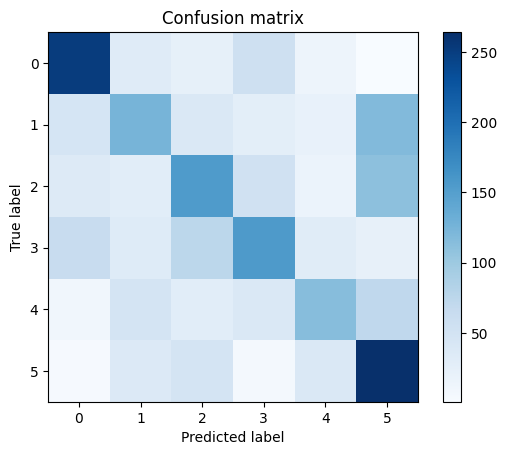

Most confusing classes: (1, 5)


In [156]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# Evaluate the model on the test set
y_pred = model.predict(X_test_freq)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(Y_freq, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
f_score = f1_score(y_test_classes, y_pred_classes, average='weighted')
print('Accuracy:', accuracy)
print('F-score:', f_score)

# Plot the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(6)
plt.xticks(tick_marks, range(6))
plt.yticks(tick_marks, range(6))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Find the most confusinglabels
np.fill_diagonal(cm, 0)
most_confused_classes = np.unravel_index(np.argmax(cm), cm.shape)
print('Most confusing classes:', most_confused_classes)

In [ ]:
def loadAudioFreqA(audio_files):
  classes = ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"]
  # for data augmentation
  augmentations = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.01, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5)
])
  # max_length = getMaxLen(audio_files)
  max_length = 200
  D, Y = [], []
  for audio_file in audio_files: 
    # load the audio file
    audio, sr = lib.load(audio_file, sr=4444)
    # extract mel spectrogram
    mel_spec = melSpectrogram(audio, sr)
    D.append(mel_spec)
    for cls in classes:
      if re.search(cls, audio_file): Y.append(cls)
    # don't augment every example
    if np.random.rand() >= 0.5:
      augmented_audio = augmentations(samples=audio, sample_rate=sr)
      mel_spec_aug = melSpectrogram(augmented_audio, sr)
      D.append(mel_spec_aug)
      for cls in classes:
        if re.search(cls, audio_file): Y.append(cls)
  return D, Y

## Time Domain Model Without Augmentation

In [194]:
def loadAudioTimeA(audio_files):
  classes = ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"]
  # for data augmentation
  augmentations = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.01, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5)
])
  # max_length = getMaxLen(audio_files)
  max_length = 200
  D, Y = [], []
  for audio_file in audio_files: 
    # load the audio file
    audio, sr = lib.load(audio_file, sr=4444)
    # extract zero crossing rate
    zcr = zeroCrossingRate(audio)
    # extract energy
    rms = energy(audio)
    # chroma stft
    cs = chromaStft(audio, sr)
    # mfcc
    mfc = mfcc(audio, sr)
    # extract mel spectrogram
    mel_spec = melSpectrogram(audio, sr).mean()
    combined_features = np.concatenate(([rms, cs, mfc, mel_spec], (np.pad(zcr[0], (0, 300 - len(zcr[0]))))))
    D.append(combined_features)
    for cls in classes:
      if re.search(cls, audio_file): Y.append(cls)
    # don't augment every example
    if np.random.rand() >= 0.5:
      augmented_audio = augmentations(samples=audio, sample_rate=sr)
      # extract zero crossing rate
      zcr = zeroCrossingRate(augmented_audio)
      # extract energy
      rms = energy(augmented_audio)
      # chroma stft
      cs = chromaStft(augmented_audio, sr)
      # mfcc
      mfc = mfcc(augmented_audio, sr)
      # extract mel spectrogram
      mel_spec = melSpectrogram(augmented_audio, sr).mean()
      combined_features = np.concatenate(([rms, cs, mfc, mel_spec], (np.pad(zcr[0], (0, 300 - len(zcr[0]))))))
      D.append(combined_features)
      for cls in classes:
        if re.search(cls, audio_file): Y.append(cls)
  return D, Y

In [195]:
D_time, Y_time = loadAudioTimeA(D_train)

/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


In [196]:
D_time = np.array(D_time)
D_time.shape

(7804, 304)

In [197]:
unicheck = np.unique(Y_time, axis=0)
print(f"Check on time domain:\n{unicheck}")

Check on time domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [198]:
df_time = pd.DataFrame(Y_time)
df_time.head()

,0
0,DIS
1,DIS
2,FEA
3,FEA
4,DIS


In [199]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_time)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(7804, 6)


In [200]:
Y_time = one_hot_labels
Y_time.shape

(7804, 6)

In [201]:
# Apply PCA to the data
pca = PCA(n_components=200)
D_pca = pca.fit_transform(D_time)

In [202]:
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(np.array(D_pca), np.array(Y_time), test_size=0.05, random_state=69, shuffle=True, stratify=Y_time)
print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

model = Sequential()
model.add(Conv1D(128, 3, input_shape=(x_train.shape[1], 1), kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(256, 3, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(512, 3, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(1024, 3,  kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(512, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(lr=0.0005),
             metrics=['accuracy'])

# Specify thecallbacks for the model
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

model.summary()

# Train the model with early stopping
history = model.fit(x_train, y_train,
                    validation_data=(x_train, y_train),
                    epochs=50,
                    batch_size=32,
                    callbacks=callbacks)

((7413, 200), (7413, 6), (391, 200), (391, 6))
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 198, 128)          512       
                                                                 
 batch_normalization_14 (Bat  (None, 198, 128)         512       
 chNormalization)                                                
                                                                 
 activation_14 (Activation)  (None, 198, 128)          0         
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 99, 128)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 97, 256)           98560     
                                                                 
 batch_

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
232/232 [==============================] - 9s 25ms/step - loss: 3.2822 - accuracy: 0.2871 - val_loss: 3.2272 - val_accuracy: 0.1566
Epoch 2/50
232/232 [==============================] - 5s 20ms/step - loss: 2.6687 - accuracy: 0.3221 - val_loss: 2.7287 - val_accuracy: 0.1804
Epoch 3/50
232/232 [==============================] - 5s 22ms/step - loss: 2.4346 - accuracy: 0.3456 - val_loss: 2.4404 - val_accuracy: 0.3010
Epoch 4/50
232/232 [==============================] - 4s 18ms/step - loss: 2.3140 - accuracy: 0.3480 - val_loss: 2.2519 - val_accuracy: 0.3733
Epoch 5/50
232/232 [==============================] - 4s 19ms/step - loss: 2.2140 - accuracy: 0.3617 - val_loss: 2.1308 - val_accuracy: 0.3650
Epoch 6/50
232/232 [==============================] - 5s 20ms/step - loss: 2.1195 - accuracy: 0.3745 - val_loss: 2.0929 - val_accuracy: 0.3687
Epoch 7/50
232/232 [==============================] - 5s 20ms/step - loss: 2.0501 - accuracy: 0.3646 - val_loss: 2.0403 - val_accuracy: 0.3403

In [203]:
X_test_time,Y_test_time = loadAudioTimeA(D_test)
D_test_pca = pca.transform(X_test_time)

In [204]:
unicheck = np.unique(Y_test_time, axis=0)
print(f"Check on freq domain:\n{unicheck}")

Check on freq domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [205]:
df_freq = pd.DataFrame(Y_test_time)
df_freq.head()

,0
0,NEU
1,DIS
2,DIS
3,HAP
4,HAP


In [206]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_freq)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(3406, 6)


In [207]:
Y_time = one_hot_labels
Y_time.shape

(3406, 6)

107/107 [==============================] - 1s 5ms/step
Accuracy: 0.3452730475631239
F-score: 0.31583205002393167


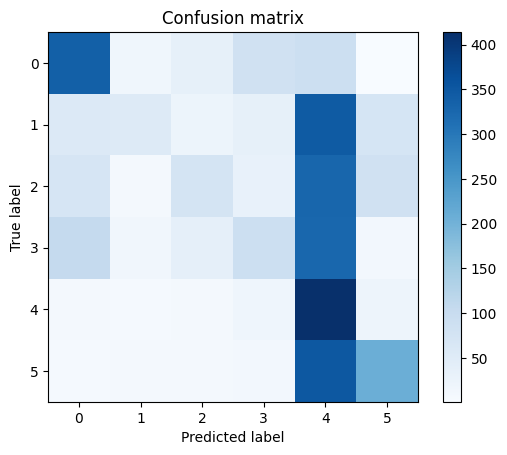

Most confusing classes: (5, 4)


In [208]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# Evaluate the model on the test set
y_pred = model.predict(D_test_pca)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(Y_time, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
f_score = f1_score(y_test_classes, y_pred_classes, average='weighted')
print('Accuracy:', accuracy)
print('F-score:', f_score)

# Plot the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(6)
plt.xticks(tick_marks, range(6))
plt.yticks(tick_marks, range(6))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Find the most confusinglabels
np.fill_diagonal(cm, 0)
most_confused_classes = np.unravel_index(np.argmax(cm), cm.shape)
print('Most confusing classes:', most_confused_classes)

## Frequency Domain Model With Augmentation

In [173]:
def loadAudioFreqA(audio_files):
  classes = ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"]
  # for data augmentation
  augmentations = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.01, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5)
])
  # max_length = getMaxLen(audio_files)
  max_length = 200
  D, Y = [], []
  for audio_file in audio_files: 
    # load the audio file
    audio, sr = lib.load(audio_file, sr=4444)
    # extract mel spectrogram
    mel_spec = melSpectrogram(audio, sr)
    D.append(mel_spec)
    for cls in classes:
      if re.search(cls, audio_file): Y.append(cls)
    # don't augment every example
    if np.random.rand() >= 0.5:
      augmented_audio = augmentations(samples=audio, sample_rate=sr)
      mel_spec_aug = melSpectrogram(augmented_audio, sr)
      D.append(mel_spec_aug)
      for cls in classes:
        if re.search(cls, audio_file): Y.append(cls)
  return D, Y

In [174]:
D_freq, Y_freq = loadAudioFreqA(D_train)

In [175]:
unicheck = np.unique(Y_freq, axis=0)
print(f"Check on freq domain:\n{unicheck}")

Check on freq domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [176]:
df_freq = pd.DataFrame(Y_freq)
df_freq.head()

,0
0,DIS
1,FEA
2,FEA
3,DIS
4,DIS


In [177]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_freq)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(7832, 6)


In [178]:
Y_freq = one_hot_labels
Y_freq.shape

(7832, 6)

In [179]:
for i, array in enumerate(D_freq):
    D_freq[i] = np.pad(array, ((0, 0), (0, 256 - array.shape[1])))
D_freq = np.array(D_freq)

In [180]:
D_freq.shape

(7832, 64, 256)

In [181]:
x_train, x_test, y_train, y_test = train_test_split(np.array(D_freq), np.array(Y_freq), test_size=0.05)
print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))

((7440, 64, 256), (7440, 6), (392, 64, 256), (392, 6))


In [182]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
print(x_train.shape, x_test.shape)

(7440, 64, 256, 1) (392, 64, 256, 1)


In [183]:
model = Sequential()

# Layer 1: Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2: Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3: Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4: Flatten Layer
model.add(Flatten())

# Layer 5: Fully Connected Layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Layer 6: Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Layer 7: Output Layer
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(lr=0.0005),
             metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 254, 32)       320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 31, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 125, 64)       18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 60, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 6, 30, 128)      

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [184]:
# Specify thecallbacks for the model
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks)

Epoch 1/50
59/59 [==============================] - 4s 63ms/step - loss: 1.8745 - accuracy: 0.2203 - val_loss: 1.6953 - val_accuracy: 0.2730
Epoch 2/50
59/59 [==============================] - 3s 51ms/step - loss: 1.6646 - accuracy: 0.2965 - val_loss: 1.5544 - val_accuracy: 0.3597
Epoch 3/50
59/59 [==============================] - 3s 51ms/step - loss: 1.6079 - accuracy: 0.3237 - val_loss: 1.5682 - val_accuracy: 0.3699
Epoch 4/50
59/59 [==============================] - 3s 49ms/step - loss: 1.5802 - accuracy: 0.3380 - val_loss: 1.5261 - val_accuracy: 0.3980
Epoch 5/50
59/59 [==============================] - 3s 49ms/step - loss: 1.5435 - accuracy: 0.3663 - val_loss: 1.5230 - val_accuracy: 0.3827
Epoch 6/50
59/59 [==============================] - 3s 49ms/step - loss: 1.5089 - accuracy: 0.3734 - val_loss: 1.4478 - val_accuracy: 0.4031
Epoch 7/50
59/59 [==============================] - 3s 52ms/step - loss: 1.5036 - accuracy: 0.3841 - val_loss: 1.4435 - val_accuracy: 0.4107
Epoch 8/50
59

In [185]:
X_test_freq,Y_test_freq = loadAudioFreqA(D_test)


In [186]:
unicheck = np.unique(Y_test_freq, axis=0)
print(f"Check on freq domain:\n{unicheck}")

Check on freq domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [187]:
df_freq = pd.DataFrame(Y_test_freq)
df_freq.head()

,0
0,NEU
1,NEU
2,DIS
3,DIS
4,HAP


In [188]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_freq)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(3342, 6)


In [189]:
Y_freq = one_hot_labels
Y_freq.shape

(3342, 6)

In [190]:
for i, array in enumerate(X_test_freq):
    X_test_freq[i] = np.pad(array, ((0, 0), (0, 256 - array.shape[1])))
X_test_freq = np.array(X_test_freq)
print( X_test_freq.shape)
#x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
#X_test_freq = x_test.reshape(( X_test_freq.shape[0],  X_test_freq.shape[1], X_test_freq.shape[2], 1))
print( X_test_freq.shape)

(3342, 64, 256)
(3342, 64, 256)


105/105 [==============================] - 1s 6ms/step
Accuracy: 0.4850388988629563
F-score: 0.4824389326161153


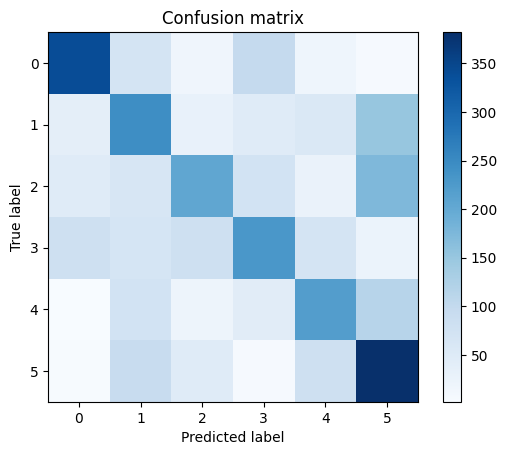

Most confusing classes: (2, 5)


In [191]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# Evaluate the model on the test set
y_pred = model.predict(X_test_freq)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(Y_freq, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
f_score = f1_score(y_test_classes, y_pred_classes, average='weighted')
print('Accuracy:', accuracy)
print('F-score:', f_score)

# Plot the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(6)
plt.xticks(tick_marks, range(6))
plt.yticks(tick_marks, range(6))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Find the most confusinglabels
np.fill_diagonal(cm, 0)
most_confused_classes = np.unravel_index(np.argmax(cm), cm.shape)
print('Most confusing classes:', most_confused_classes)

## Time Domain Model With Augmentation

In [ ]:
D_time, Y_time = loadAudioTimeA(D_train)

In [ ]:
D_time = np.array(D_time)
D_time.shape

In [ ]:
unicheck = np.unique(Y_time, axis=0)
print(f"Check on time domain:\n{unicheck}")

In [ ]:
df_time = pd.DataFrame(Y_time)
df_time.head()

In [ ]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_time)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

In [ ]:
Y_time = one_hot_labels
Y_time.shape

In [ ]:
# Apply PCA to the data
pca = PCA(n_components=200)
D_pca = pca.fit_transform(D_time)

In [ ]:
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(np.array(D_pca), np.array(Y_time), test_size=0.05, random_state=69, shuffle=True, stratify=Y_time)
print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

model = Sequential()
model.add(Conv1D(128, 3, input_shape=(x_train.shape[1], 1), kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(256, 3, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(512, 3, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(1024, 3,  kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(512, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(lr=0.0005),
             metrics=['accuracy'])

# Specify thecallbacks for the model
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

model.summary()

# Train the model with early stopping
history = model.fit(x_train, y_train,
                    validation_data=(x_train, y_train),
                    epochs=50,
                    batch_size=32,
                    callbacks=callbacks)

In [ ]:
X_test_time,Y_test_time = loadAudioTime(D_test)
D_test_pca = pca.transform(X_test_time)

In [ ]:
unicheck = np.unique(Y_test_time, axis=0)
print(f"Check on freq domain:\n{unicheck}")

In [ ]:
df_freq = pd.DataFrame(Y_test_time)
df_freq.head()

In [ ]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_freq)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

In [ ]:
Y_time = one_hot_labels
Y_time.shape

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# Evaluate the model on the test set
y_pred = model.predict(D_test_pca)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(Y_time, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
f_score = f1_score(y_test_classes, y_pred_classes, average='weighted')
print('Accuracy:', accuracy)
print('F-score:', f_score)

# Plot the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(6)
plt.xticks(tick_marks, range(6))
plt.yticks(tick_marks, range(6))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Find the most confusinglabels
np.fill_diagonal(cm, 0)
most_confused_classes = np.unravel_index(np.argmax(cm), cm.shape)
print('Most confusing classes:', most_confused_classes)

In [ ]:
def loadAudioTime(audio_files):
  classes = ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"]
  # for data augmentation
  augmentations = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.01, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5)
])
  # max_length = getMaxLen(audio_files)
  max_length = 200
  D, Y = [], []
  for audio_file in audio_files: 
    # load the audio file
    audio, sr = lib.load(audio_file, sr=4444)
    # extract zero crossing rate
    zcr = zeroCrossingRate(audio)
    # extract energy
    rms = energy(audio)
    # chroma stft
    cs = chromaStft(audio, sr)
    # mfcc
    mfc = mfcc(audio, sr)
    # extract mel spectrogram
    #mel_spec = melSpectrogram(audio, sr).mean()
    combined_features = np.concatenate(([rms, cs, mfc], (np.pad(zcr[0], (0, 300 - len(zcr[0]))))))
    D.append(combined_features)
    for cls in classes:
      if re.search(cls, audio_file): Y.append(cls)
    # don't augment every example
    if np.random.rand() >= 0.5:
      augmented_audio = augmentations(samples=audio, sample_rate=sr)
      # extract zero crossing rate
      zcr = zeroCrossingRate(augmented_audio)
      # extract energy
      rms = energy(augmented_audio)
      # chroma stft
      cs = chromaStft(augmented_audio, sr)
      # mfcc
      mfc = mfcc(augmented_audio, sr)
      # extract mel spectrogram
      #mel_spec = melSpectrogram(augmented_audio, sr).mean()
      combined_features = np.concatenate(([rms, cs, mfc], (np.pad(zcr[0], (0, 300 - len(zcr[0]))))))
      D.append(combined_features)
      for cls in classes:
        if re.search(cls, audio_file): Y.append(cls)
  return D, Y

In [ ]:
D_time, Y_time = loadAudioTime(D_train)

/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


In [ ]:
D_time = np.array(D_time)
D_time.shape

(7835, 303)

In [ ]:
unicheck = np.unique(Y_time, axis=0)
print(f"Check on time domain:\n{unicheck}")

Check on time domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [ ]:
df_time = pd.DataFrame(Y_time)
df_time.head()

,0
0,SAD
1,FEA
2,SAD
3,SAD
4,ANG


In [ ]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_time)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(7835, 6)


In [ ]:
Y_time = one_hot_labels
Y_time.shape

(7835, 6)

In [ ]:
# Apply PCA to the data
pca = PCA(n_components=200)
D_pca = pca.fit_transform(D_time)

In [ ]:
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(np.array(D_pca), np.array(Y_time), test_size=0.05, random_state=69, shuffle=True, stratify=Y_time)
print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

model = Sequential()
model.add(Conv1D(128, 3, input_shape=(x_train.shape[1], 1), kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(256, 3, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(512, 3, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(1024, 3,  kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(512, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(lr=0.0005),
             metrics=['accuracy'])

# Specify thecallbacks for the model
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

model.summary()

# Train the model with early stopping
history = model.fit(x_train, y_train,
                    validation_data=(x_train, y_train),
                    epochs=50,
                    batch_size=32,
                    callbacks=callbacks)

((7443, 200), (7443, 6), (392, 200), (392, 6))
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 198, 128)          512       
                                                                 
 batch_normalization_7 (Batc  (None, 198, 128)         512       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 198, 128)          0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 99, 128)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 97, 256)           98560     
                                                                 
 batch_

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
233/233 [==============================] - 8s 23ms/step - loss: 3.4641 - accuracy: 0.2769 - val_loss: 3.5970 - val_accuracy: 0.1464
Epoch 2/50
233/233 [==============================] - 4s 18ms/step - loss: 2.8334 - accuracy: 0.3184 - val_loss: 3.0989 - val_accuracy: 0.1493
Epoch 3/50
233/233 [==============================] - 5s 22ms/step - loss: 2.5740 - accuracy: 0.3364 - val_loss: 2.4826 - val_accuracy: 0.3419
Epoch 4/50
233/233 [==============================] - 5s 19ms/step - loss: 2.4003 - accuracy: 0.3614 - val_loss: 2.3931 - val_accuracy: 0.3345
Epoch 5/50
233/233 [==============================] - 4s 18ms/step - loss: 2.2647 - accuracy: 0.3800 - val_loss: 2.5308 - val_accuracy: 0.2851
Epoch 6/50
233/233 [==============================] - 5s 21ms/step - loss: 2.1824 - accuracy: 0.3740 - val_loss: 2.3478 - val_accuracy: 0.2699
Epoch 7/50
233/233 [==============================] - 4s 18ms/step - loss: 2.0951 - accuracy: 0.3910 - val_loss: 2.1000 - val_accuracy: 0.3787

**Without Augmentation**

In [ ]:
def getMaxLen(audio_files):
  max_length = 0
  for audio_file in audio_files:
    audio, _ = librosa.load(audio_file)
    length = len(audio)
    max_length = max(max_length, length)
  return max_length

In [ ]:
def loadAudioTime(audio_files):
  classes = ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"]
  #1D WITHOUT MEL
  # max_length = getMaxLen(audio_files)
  max_length = 200
  D, Y = [], []
  for audio_file in audio_files: 
    # load the audio file
    audio, sr = lib.load(audio_file, sr=4444)
    # extract zero crossing rate
    zcr = zeroCrossingRate(audio)
    # extract energy
    rms = energy(audio)
    # chroma stft
    cs = chromaStft(audio, sr)
    # mfcc
    mfc = mfcc(audio, sr)
    # extract mel spectrogram
    #mel_spec = melSpectrogram(audio, sr).mean()
    combined_features = np.concatenate(([rms, cs, mfc], (np.pad(zcr[0], (0, 300 - len(zcr[0]))))))
    D.append(combined_features)
    for cls in classes:
      if re.search(cls, audio_file): Y.append(cls)
  return D,Y
  

In [ ]:
def loadAudioFreq(audio_files):
  classes = ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"]
  
  # max_length = getMaxLen(audio_files)
  max_length = 200
  D, Y = [], []
  for audio_file in audio_files: 
    # load the audio file
    audio, sr = lib.load(audio_file, sr=4444)
    # extract mel spectrogram
    mel_spec = melSpectrogram(audio, sr)
    D.append(mel_spec)
    for cls in classes:
      if re.search(cls, audio_file): Y.append(cls)
    
  return D, Y

In [ ]:
D_time, Y_time = loadAudioTime(D_train)

/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


In [ ]:
D_time = np.array(D_time)
D_time.shape

(5216, 303)

In [ ]:
unicheck = np.unique(Y_time, axis=0)
print(f"Check on time domain:\n{unicheck}")

Check on time domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [ ]:
df_time = pd.DataFrame(Y_time)
df_time.head()

,0
0,SAD
1,FEA
2,SAD
3,ANG
4,SAD


In [ ]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_time)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(5216, 6)


In [ ]:
Y_time = one_hot_labels
Y_time.shape

(5216, 6)

In [ ]:
# Apply PCA to the data
pca = PCA(n_components=200)
D_pca = pca.fit_transform(D_time)

In [ ]:
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(np.array(D_pca), np.array(Y_time), test_size=0.05, random_state=69, shuffle=True, stratify=Y_time)
print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

model = Sequential()
model.add(Conv1D(128, 3, input_shape=(x_train.shape[1], 1), kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(256, 3, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(512, 3, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(1024, 3,  kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(512, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(lr=0.0005),
             metrics=['accuracy'])

# Specify thecallbacks for the model
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

model.summary()

# Train the model with early stopping
history = model.fit(x_train, y_train,
                    validation_data=(x_train, y_train),
                    epochs=50,
                    batch_size=32,
                    callbacks=callbacks)

((4955, 200), (4955, 6), (261, 200), (261, 6))
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 198, 128)          512       
                                                                 
 batch_normalization_14 (Bat  (None, 198, 128)         512       
 chNormalization)                                                
                                                                 
 activation_14 (Activation)  (None, 198, 128)          0         
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 99, 128)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 97, 256)           98560     
                                                                 
 batch_

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
155/155 [==============================] - 8s 32ms/step - loss: 3.5517 - accuracy: 0.3017 - val_loss: 3.8160 - val_accuracy: 0.1487
Epoch 2/50
155/155 [==============================] - 4s 27ms/step - loss: 2.9751 - accuracy: 0.3453 - val_loss: 3.9389 - val_accuracy: 0.1485
Epoch 3/50
155/155 [==============================] - 4s 23ms/step - loss: 2.7073 - accuracy: 0.3556 - val_loss: 3.1230 - val_accuracy: 0.1713
Epoch 4/50
155/155 [==============================] - 4s 24ms/step - loss: 2.5311 - accuracy: 0.3713 - val_loss: 2.7442 - val_accuracy: 0.2367
Epoch 5/50
155/155 [==============================] - 4s 26ms/step - loss: 2.4056 - accuracy: 0.3816 - val_loss: 2.6156 - val_accuracy: 0.2767
Epoch 6/50
155/155 [==============================] - 3s 22ms/step - loss: 2.3046 - accuracy: 0.4014 - val_loss: 2.2470 - val_accuracy: 0.4113
Epoch 7/50
155/155 [==============================] - 3s 22ms/step - loss: 2.2187 - accuracy: 0.4061 - val_loss: 2.4193 - val_accuracy: 0.3407

In [ ]:
D_freq, Y_freq = loadAudioFreq(D_train)

In [ ]:
unicheck = np.unique(Y_freq, axis=0)
print(f"Check on freq domain:\n{unicheck}")

Check on freq domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [ ]:
df_freq = pd.DataFrame(Y_freq)
df_freq.head()

,0
0,SAD
1,FEA
2,SAD
3,ANG
4,SAD


In [ ]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_freq)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(5216, 6)


In [ ]:
Y_freq = one_hot_labels
Y_freq.shape

(5216, 6)

In [ ]:
for i, array in enumerate(D_freq):
    D_freq[i] = np.pad(array, ((0, 0), (0, 256 - array.shape[1])))
D_freq = np.array(D_freq)

In [ ]:
D_freq.shape

(5216, 64, 256)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.array(D_freq), np.array(Y_freq), test_size=0.05)
print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))

((4955, 64, 256), (4955, 6), (261, 64, 256), (261, 6))


In [ ]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
print(x_train.shape, x_test.shape)

(4955, 64, 256, 1) (261, 64, 256, 1)


In [ ]:
model = Sequential()

# Layer 1: Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2: Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3: Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4: Flatten Layer
model.add(Flatten())

# Layer 5: Fully Connected Layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Layer 6: Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Layer 7: Output Layer
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(lr=0.0005),
             metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 254, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 127, 32)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 125, 64)       18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 60, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 30, 128)      

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Specify thecallbacks for the model
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks)

Epoch 1/50
39/39 [==============================] - 4s 90ms/step - loss: 1.9025 - accuracy: 0.2194 - val_loss: 1.5908 - val_accuracy: 0.4061
Epoch 2/50
39/39 [==============================] - 2s 50ms/step - loss: 1.6561 - accuracy: 0.3021 - val_loss: 1.5124 - val_accuracy: 0.4253
Epoch 3/50
39/39 [==============================] - 2s 53ms/step - loss: 1.5916 - accuracy: 0.3330 - val_loss: 1.4681 - val_accuracy: 0.3946
Epoch 4/50
39/39 [==============================] - 2s 53ms/step - loss: 1.5523 - accuracy: 0.3514 - val_loss: 1.4942 - val_accuracy: 0.3640
Epoch 5/50
39/39 [==============================] - 2s 51ms/step - loss: 1.5189 - accuracy: 0.3756 - val_loss: 1.4540 - val_accuracy: 0.4061
Epoch 6/50
39/39 [==============================] - 2s 51ms/step - loss: 1.4986 - accuracy: 0.3796 - val_loss: 1.4173 - val_accuracy: 0.4406
Epoch 7/50
39/39 [==============================] - 2s 51ms/step - loss: 1.4694 - accuracy: 0.3964 - val_loss: 1.4275 - val_accuracy: 0.4330
Epoch 8/50
39